# Úkol č. 1 - předzpracování dat a binární klasifikace

* Termíny jsou uvedeny na [courses.fit.cvut.cz/BI-ML1/homeworks/index.html](https://courses.fit.cvut.cz/BI-ML1/homeworks/index.html).
* Pokud odevzdáte úkol po prvním termínu ale před nejzazším termínem, budete penalizování -12 body, pozdější odevzdání je bez bodu.
* V rámci tohoto úkolu se musíte vypořádat s klasifikační úlohou s příznaky různých typů a s chybějícími hodnotami.
* Před tím, než na nich postavíte predikční model, je třeba je nějakým způsobem převést do číselné reprezentace.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budeme strhávat body.

## Zdroj dat

Budeme se zabývat predikcí přežití pasažérů Titaniku.
K dispozici máte trénovací data v souboru `data.csv` a data na vyhodnocení v souboru `evaluation.csv`.

#### Seznam příznaků:
* survived - zda pasažér přežil, 0 = Ne, 1 = Ano; **vysvětlovaná proměnná**, kterou chcete predikovat
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**: 
  * V notebooku načtěte data ze souboru `data.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování (trénovací), porovnávání modelů (validační) a následnou predikci výkonnosti finálního modelu (testovací).
    
  * Proveďte základní předzpracování dat:
    * Projděte si jednotlivé příznaky a transformujte je do vhodné podoby pro použití ve vybraném klasifikačním modelu.
    * Podle potřeby si můžete vytvářet nové příznaky (na základě existujících), například tedy můžete vytvořit příznak měřící délku jména atp.
    * Některé příznaky můžete také úplně zahodit.
    * Nějakým způsobem (klidně triviálním) se vypořádejte s chybějícími hodnotami. Není potřeba používat sofistikované metody. _Hlavně pozor na metodické chyby!_
    * Můžete využívat i vizualizace a vše stručně ale náležitě komentujte.

  
  * Na připravená data postupně aplikujte **rozhodovací strom** a **metodu nejbližších sousedů**, přičemž pro každý z těchto modelů:
    * Okomentujte vhodnost daného modelu pro daný typ úlohy.
    * Vyberte si hlavní hyperparametry k ladění a najděte jejich nejlepší hodnoty.
    * Pro model s nejlepšími hodnotami hyperparametrů spočtěte (na validační množině) F1 skóre, nakreslete ROC křivku a určete AUC. _Pozor na metodické chyby!_
    * Získané výsledky vždy řádně okomentujte.

        
  * Ze všech zkoušených možností v předchozím kroku vyberte finální model (jednoznačně popište o který konkrétně jde) a správně odhadněte, jakou **přesnost** můžete očekávat na nových datech, která jste doposud neměli k dispozici. _Pozor na metodické chyby!_
    
  * Nakonec načtěte vyhodnocovací data ze souboru `evaluation.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do sloupce **survived** a identifikátory do sloupce **ID** (dodržte názvy sloupců!). Tento soubor též odevzdejte (uložte do repozitáře vedle notebooku).

      * Snažte se vše udělat tak, aby přesnost odevzdaných predikcí na vyhodocovacím datasetu byla alespoň **75%**. Pokud bude menší, přijdete o **3 body**.
      * Ukázka, jak by mělo vypadat prvních několik řádků souboru `results.csv` (obecně s jinými hodnotami survived):
  
```
ID,survived
1000,0
1001,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML1/homeworks/index.html.
  * Vytvořte i csv soubor `results.csv` s predikcemi a uložte ho v rámci projektu vedle ipython notebooku.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

## Read and divide data into three groups (train, val, test)

In [2]:
raw_df = pd.read_csv('data.csv')
Xdata = raw_df.drop(columns='survived')
ydata = raw_df['survived']

r_seed = 1111 # Random seed for a debug reason
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.4, random_state=r_seed) 
Xval, Xtest, yval, ytest = train_test_split(Xtest, ytest, test_size=0.5, random_state=r_seed) 

## Create scikit piplines

I am going to use **Scikit-learn pipeline** for **data preprocessing** and **further model tuning**.

First of all, I need to identify features I am going to drop this ones (other will be used):
* **name**: The name itself does not provide useful predictive information.
* **ticket**: The ticket number is likely a unique identifier and does not hold any intrinsic predictive value.
* **cabin**: While cabin information might theoretically provide insights (e.g., proximity to lifeboats), the large number of missing values makes it unreliable and challenging to preprocess effectively.
* **home.dest**: The feature is too specific and might introduce noise rather than valuable predictive information.

In [3]:
numerical_features = ['age', 'sibsp', 'parch', 'fare']
categorical_features = ['pclass', 'sex', 'embarked']

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

Secondly, I got to create transformers for each group and then combine them into a single ColumnTransformer. I decided to use mean strategy for imputing NA values for numerical features, for categorical features most frequent value will be used. For numerical values StandardScaler() will be used and for categorical OneHotEncoder() that for unknown categories will fill zeros in rows.

In [5]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # pipeline will 'remember' mean value on .fit() 
                                                 # and then it will use it to preprocess data for predition
    ('std_scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('1hot_encoder', OneHotEncoder(handle_unknown='ignore'))
])

col_trans = ColumnTransformer(
    transformers=[
        ('num_trans', numerical_transformer, numerical_features),
        ('cat_trans', categorical_transformer, categorical_features)
    ],
    remainder='drop',  # Dropping other features
    n_jobs=-1          # Use all available processors
)

Let's finally combine our preprocessor and needed classifiers (DecisionTree and KNN) into seperate pipelines:

In [6]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier

In [7]:
dtree_pipe = Pipeline(steps=[
    ('preprocesser', col_trans),
    ('classifier', DecisionTreeClassifier(random_state=r_seed)) # Again, r_seed for a debug reason
])

knn_pipe = Pipeline(steps=[
    ('preprocesser', col_trans),
    ('classifier', KNeighborsClassifier())
])
display(dtree_pipe)
display(knn_pipe)

Pipeline(steps=[('preprocesser',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_trans',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare']),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('1hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['pclass', 'sex',
                                                   'embarked'])])),
                ('classifier', DecisionTreeClassifier(random_state=1111))])

Pipeline(steps=[('preprocesser',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_trans',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare']),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('1hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['pclass', 'sex',
                                                   'embarked'])])),
                ('classifier', KNeighborsClassifier())])

## Decision Tree

**Suitability of Decision Tree for this problem:**
+ can handle complex, non-linear relationships between features, which may be present in this dataset. For example, survival might not have a simple linear relationship with fare or age but rather interact in more complex ways.
+ relatively fast to train and predict with, especially on datasets of this size.

But on the other hand:
+ are prone to overfitting.
+ may be biased towards the majority class if the dataset is imbalanced (i.e., more non-survivors than survivors).
+ are unstable, (small changes in the training data can lead to significantly different tree structures)

In [8]:
from sklearn.model_selection import ParameterGrid
import sklearn.metrics as metrics

We will use **ParameterGrid** to iterate over and find the best combination of the hyperparameters. The main ones here are criterion, max_depth, min_samples_split and min_samples_leaf. (I know that I here perform unnecessary data preprocessing over and over again, I could have done it before, and only after choosing the best model combine those piplines into one, but it is **irrelevant** on such a small dataset).

Also I'll use **F1 score** metric for measuring the performance of classification models because we have **imbalanced data**:

In [9]:
print(f'''In balanced dataset the number of Positive and Negative labels is about equal.
But we have only {ytrain.sum()*100/ytrain.count():.2f}% of Positive lables.''')

In balanced dataset the number of Positive and Negative labels is about equal.
But we have only 36.67% of Positive lables.


In [10]:
dtree_param_grid = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

dtree_best_f1 = 0
dtree_best_params = None

# Iterate over params
for params in ParameterGrid(dtree_param_grid):
    dtree_pipe.set_params(**params)
    dtree_pipe.fit(Xtrain, ytrain)
    
    # Predict and evaluate on a validation data set
    yval_pred = dtree_pipe.predict(Xval)
    f1 = metrics.f1_score(yval, yval_pred)
    
    # Update best pipe
    if f1 > dtree_best_f1:
        dtree_best_f1 = f1
        dtree_best_params = params

Reconstuct the model with determined optimal params:

Best params are: {'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
F1 score: 0.7724
For pipeline:


Pipeline(steps=[('preprocesser',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_trans',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare']),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('1hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['pclass', 'sex',
                                                   'embarked'])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=3, random_state=1111))])

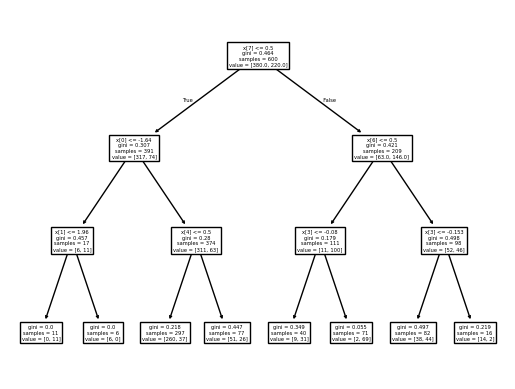

In [11]:
from copy import deepcopy
# Reconstruct dtree
dtree_best_pipe = deepcopy(dtree_pipe) # sklearn.base.clone could be better here but I'm not completely sure
dtree_best_pipe.set_params(**dtree_best_params)
dtree_best_pipe.fit(Xtrain, ytrain)

print(f"Best params are: {dtree_best_params}")
print(f"F1 score: {dtree_best_f1:.4}\nFor pipeline:")
display(dtree_best_pipe)
plot_tree(dtree_best_pipe['classifier']);

### ROC and AUC

In [12]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [13]:
def print_roc(ax, fpr, tpr, roc_auc, title):
    ax.plot(fpr, tpr, label=f'{title} (AUC = {roc_auc:.5})')
    ax.plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax.set_xlabel('FP Rate')
    ax.set_ylabel('TP Rate')
    ax.set_title(f'ROC Curve for Best {title}')
    ax.legend()

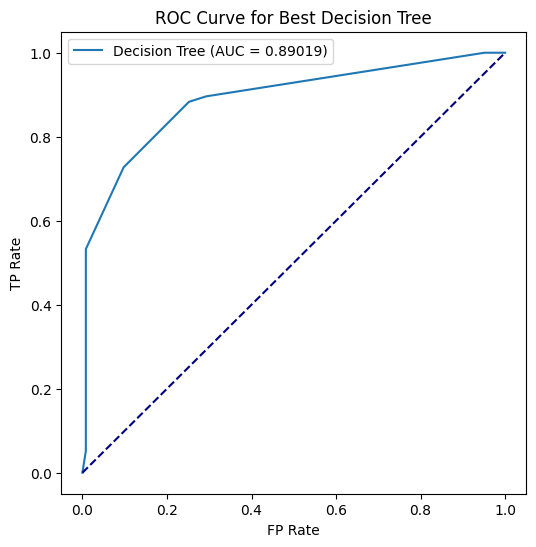

In [14]:
dtree_yval_proba = dtree_best_pipe.predict_proba(Xval)[:, 1]  # Probabilities for ROC and AUC calculation
dtree_roc_auc = metrics.roc_auc_score(yval, dtree_yval_proba)
dtree_fpr, dtree_tpr, _ = metrics.roc_curve(yval, dtree_yval_proba)

# Plot ROC Curve
fig, ax = plt.subplots(figsize=(6, 6))
print_roc(ax, dtree_fpr, dtree_tpr, dtree_roc_auc, 'Decision Tree')

## KNN

**Suitability of K-Nearest Neighbors method for this problem:**
+ makes predictions based on the class of neighboring samples, aligning well with the intuitive reasoning.
+ simplicity and direct applicability.

But on the other hand:
+ have sensitivity to feature scaling (scaling one feature have a drastic influence on other features).
+ can be computationally expensive (but not for this small dataset).

I'll perform the same steps as before:

In [15]:
knn_param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 10],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]                         # Metric (1 = Manhattan, 2 = Euclidean)
}

knn_best_f1 = 0
knn_best_params = None

# Iterate over params
for params in ParameterGrid(knn_param_grid):
    knn_pipe.set_params(**params)
    knn_pipe.fit(Xtrain, ytrain)
    
    # Predict and evaluate on a validation data set
    yval_pred = knn_pipe.predict(Xval)
    f1 = metrics.f1_score(yval, yval_pred)
    
    # Update best pipe
    if f1 > knn_best_f1:
        knn_best_f1 = f1
        knn_best_params = params

# Reconstruct the model
knn_best_pipe = deepcopy(knn_pipe)
knn_best_pipe.set_params(**knn_best_params)
knn_best_pipe.fit(Xtrain, ytrain)

print(f"Best params are: {knn_best_params}")
print(f"F1 score: {knn_best_f1:.4}\nFor pipeline:")
display(knn_best_pipe)

Best params are: {'classifier__n_neighbors': 3, 'classifier__p': 1, 'classifier__weights': 'uniform'}
F1 score: 0.7413
For pipeline:


Pipeline(steps=[('preprocesser',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_trans',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare']),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('1hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['pclass', 'sex',
                                                   'embarked'])])),
                ('classifier', KNeighborsClassifier(n_neighbors=3, p=1))])

### ROC and AUC

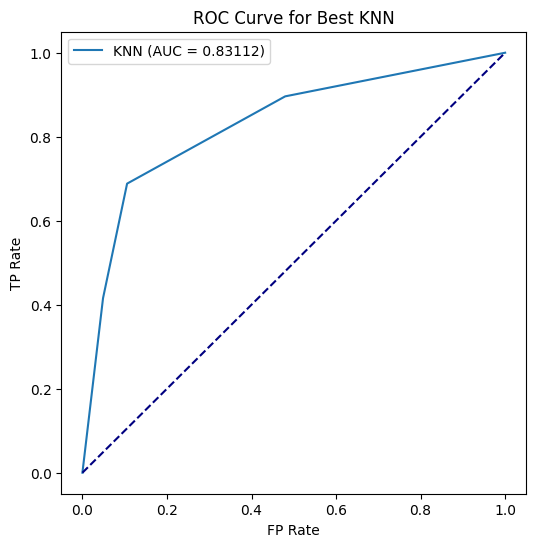

In [16]:
knn_yval_proba = knn_best_pipe.predict_proba(Xval)[:, 1]  # Probabilities for ROC and AUC calculation
knn_roc_auc = metrics.roc_auc_score(yval, knn_yval_proba)
knn_fpr, knn_tpr, _ = metrics.roc_curve(yval, knn_yval_proba)

# Plot ROC Curve
fig, ax = plt.subplots(figsize=(6, 6))
print_roc(ax, knn_fpr, knn_tpr, knn_roc_auc, 'KNN')

## Compare two models

In [17]:
print(f"Decision Tree best F1 score: {dtree_best_f1:.4}")
print(f"Decision Tree best AUC: {dtree_roc_auc:.4}\n")
print(f"KNN best F1 score: {knn_best_f1:.4}")
print(f"KNN best AUC: {knn_roc_auc:.4}\n")

Decision Tree best F1 score: 0.7724
Decision Tree best AUC: 0.8902

KNN best F1 score: 0.7413
KNN best AUC: 0.8311



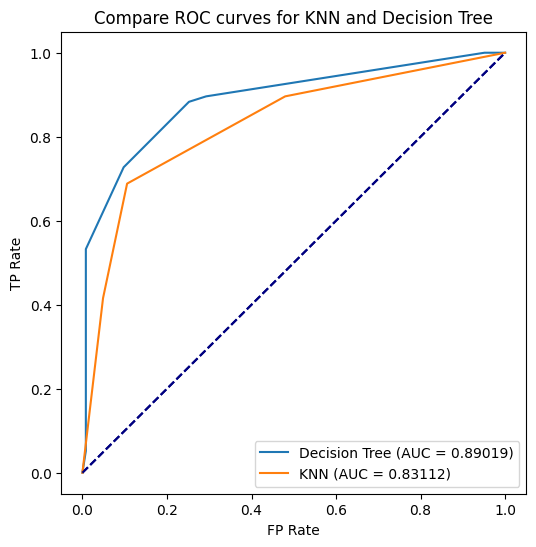

In [18]:
# Plot ROC Curves
fig, ax = plt.subplots(figsize=(6, 6))
print_roc(ax, dtree_fpr, dtree_tpr, dtree_roc_auc, 'Decision Tree')
print_roc(ax, knn_fpr, knn_tpr, knn_roc_auc, 'KNN')
ax.set_title('Compare ROC curves for KNN and Decision Tree');

The Decision Tree model tottaly outperforms the KNN model in terms of both AUC and F1 score on this Titanic survival dataset, making it the preferable choice for this classification task. The Decision Tree's higher AUC indicates high rate of true positives and low rate of false positives, and the improved F1 score reflects a more balanced approach to precision and recall.

## What **accuracy** we can expect on new data?

In [19]:
# Predict on the test dataset
ytest_pred = dtree_best_pipe.predict(Xtest)

# Calculate accuracy
test_accuracy = metrics.accuracy_score(ytest, ytest_pred)
print(f"Expected accuracy on new data: {test_accuracy:.2f}")

Expected accuracy on new data: 0.83


## Calculate results.csv

In [20]:
# Load the evaluation data
evaluation_data = pd.read_csv('evaluation.csv')

# Generate predictions using the final model
evaluation_data['survived'] = dtree_best_pipe.predict(evaluation_data)

# Save the results
results = evaluation_data[['ID', 'survived']]
results.to_csv('results.csv', index=False)